# NER - extraction and visualisation

## Pre-requisite

### gnfinder

    1. Download the latest version at: https://github.com/gnames/gnfinder/releases
    2. Dezip the file and put the gnfinder.exe in a folder (e.g. "C/bin/"") 

More info (installation, package): https://github.com/gnames/gnfinder

### spacy


    1. Install the package in the Anaconda Prompt command line: pip install spacy
    2. Install the model en_core_web_lg through the Anacaond Prompt command line: python -m spacy download en_core_web_lg    
  
 More info: https://spacy.io/models/en

## Import

### Packages and functions

In [1]:
import json
import requests
import regex as re
import pandas as pd
import matplotlib
import itertools
import inflect
import spacy
from itertools import chain
from pygbif import name_lookup
import webbrowser

nlp = spacy.load("en_core_web_lg")

In [76]:
def nercolor(out):
   
    # list of colours to highlight the entities
    d = {"location": "#9FC9C9", "date" :"#C7E5C3", "time_range": "#eec9db", "dataset_type": "#DB97C7", 
         "scientific_name" : "#FFCCA1", "vernacular_name":"#F5878B" }
    
    strh = "<html><div style='width:70%;display:inline-block'>"
    for i,j in out["tagged_text"]:
        if j == 'other':
            strh += i
            strh += " "
        if j != 'other':
            strh += "<strong><span style='background-color:%s'>" % d[j]
            strh += i
            strh += "</span></strong>"
            strh += " "
    strh += "</div></html>"

    #Legends
    stri = '<div style="width:20%;display:inline-block">'
    stri += "<table>"
    for j, i in d.items():
        stri += '<tr>'
        stri += "<td><span style='background-color: %s'>__________</span>&nbsp;</td>" %i
        stri += "<td>%s</td>" %j
        stri += '</tr>'
    stri += "</table></div>"
    
    #taxo
    taxo = '<div style="width:40%;display:inline-block">'
    taxo += "<p>"
    for k in out["taxonomy"].keys():
        for j, i in out["taxonomy"][k].items():
            j2 = j.replace("_", " ").capitalize()
            taxo += "<strong>%s: </strong>" %j2
            taxo += "%s <br>" %i
    taxo += "</p>"
    new = stri+strh + taxo
    log_file = open('article_ner.html', 'wb+')
    log_file.write(new.encode('utf-8'))
    return webbrowser.open('article_ner.html')

def tag_entities(text, vocab_dataset = [], vocab_scientific_names = [], vocab_vernacular_names = [], taxonomy = []):
    locations = detect_locations(text, type_ent = True, start = True)
    date_range = detect_time_range(text, type_ent = True, start = True, norm=False)
    date_punc = detect_dates(text)
    dates = []
    if len(date_range) >0:
        for i in date_punc:
            inc = True
            for j in date_range:
                if (i[2]==j[2]):
                    inc = False
            if inc & (i not in dates):
                dates.append(i)

    else:
        dates = date_punc
    dataset_type = detect_dataset_type(text, vocab_dataset)
    scientific_name = detect_keywords(text, kw = vocab_scientific_names, type_ent= True, ent_value = "scientific_name", start = True)
    vernacular_name = detect_keywords(text, kw = vocab_vernacular_names, type_ent= True, ent_value = "vernacular_name", start = True)
    
    # extract taxonomy
    set_vernacular_name = list(set([i[0] for i in vernacular_name]))
    set_vernacular_name = list(set(set_vernacular_name).intersection(list(taxonomy.keys())))
    taxo = dict((k, taxonomy[k]) for k in set_vernacular_name)
    
    not_loc = list(set([x[0].lower() for x in scientific_name] + [x[0].lower() for x in vernacular_name]))
    locations = [x for x in locations if x[0].lower() not in not_loc]
    entities = locations + date_range + dates + dataset_type + scientific_name + vernacular_name
    elm = 2
    entities.sort(key=lambda x: x[elm])
    entities =  list(k for k,_ in itertools.groupby(entities))
    cut_id = vec_entities(entities)
    cut1 = []
    for i in entities:
            n = len(i[0])
            cut1.append(i[2])
            cut1.append(i[2] + n)
    cut1.append(len(text))
    cut1 = list(set(cut1))
    cut1.sort()
    cut2 = [0] + cut1[:-1]
    n = [a1 - a2 for a1, a2 in zip(cut1, cut2)]
    text_sep = [text[sum(n[:i]):sum(n[:i+1])] for i in range(len(n))]
    tagged_entities = {"tagged_text": [(a1, a2) for a1, a2 in zip(text_sep, cut_id)], "taxonomy": taxo}
    return(tagged_entities)

In [3]:
def vec_entities(l_entities):
    for i, val in enumerate(l_entities):
        if (i == 0):
            if val[2] != 0:
                vec = ["other", val[1]]
            else:
                vec = val[2]
        else:
            end_prev = l_entities[i-1][2] + len(l_entities[i-1][0])
            if ((val[2] >= end_prev + 1) & (vec[-1] != "other")):
                vec.append("other")
            vec.append(val[1])
    return(vec)
        
def detect_locations(text, type_ent = True, start = True):
    locations = []
    nlp = spacy.load("en_core_web_lg")
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        if chunk.root.text.lower() in ["canada", "québec", "quebec"]:
            loc = [chunk.text]
            if type_ent:
                loc.append("location")
            if start:
                loc.append(chunk.start_char)  
            locations.append((loc))
    for e in doc.ents:
        if e.label_ in ["LOC", "GPE"]:
            loc = [e.text]
            if type_ent:
                loc.append("location")
            if start:
                loc.append(e.start_char)  
            locations.append((loc))
    #locations = list(set(locations))
    locations = list(k for k,_ in itertools.groupby(locations))
    return(locations)

def detect_dates(text, type_ent = True, start = True, min_y = 1900, max_y = 2023):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    dates = []
    for e in doc.ents:
        if "DATE" in e.label_:
            if e.text.isdigit():
                if ((int(e.text) >= min_y) & (int(e.text) <= max_y)):
                    date = [e.text]
                    if type_ent:
                        date.append("date")
                    if start:
                        date.append(e.start_char) 
                    dates.append((date))
            elif ("orcid" not in text[(max(0, (e.start_char - 10) )):e.start_char].lower()):
                date = [e.text]
                if type_ent:
                    date.append("date")
                if start:
                    date.append(e.start_char) 
                dates.append((date))
    return(dates)

def detect_time_range(text, type_ent = True, start = True, norm = True, min_y = 1900, max_y = 2023):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    time_range = []
    
    # use Spacy duration entities
    for e in doc.ents:
        if "DURATION" in e.kb_id_:
            r = r"(?<=value=).*"
            val =  re.search(r, e.kb_id_).group(0).replace('"', '')
            time = [e.text]
            if type_ent:
                time.append("time_range")
            if start:
                time.append(e.start_char) 
            if norm:
                time.append(val) 
            time_range.append((time))

    # use custom built regex
    regex_intervals = [r"(\d{4}) ?(to|-) ?(\d{4})", #  "2004-2005", "2019 to 2021"
                    r"between (\d{4}) (and) (\d{4})"]  #  "betwwen 2004 and 2021"
    
    regex_durations = [r"over (\d{1,4}) ([[:alpha:]]*)( *)year[s]?", #"over 7 years", "over 5 consecutive years"
      r"(\d{1,4})( |-)(year)[s]?"]   #  "7-years study"
    
    for reg in regex_intervals:
        result = re.finditer(reg, text.lower())
        for res in result:
            if ((int(res.group(3)) >= min_y) & (int(res.group(3)) <= max_y)):
                val = "P{}Y".format(int(res.group(3)) - int(res.group(1)))

                time = [res.group(0)]            
                if type_ent:
                    time.append("time_range")
                if start:
                    time.append(res.start(0)) 
                if norm:
                    time.append(val) 
                time_range.append((time))

    for reg in regex_durations:
        result = re.finditer(reg, text.lower())
        for res in result:
            val = "P{}Y".format(int(res.group(1)))
            
            time = [res.group(0)]            
            if type_ent:
                time.append("time_range")
            if start:
                time.append(res.start(0)) 
            if norm:
                time.append(val) 
            time_range.append((time))
    return(time_range)

def detect_dataset_type(text, kw, type_ent= True, start = True):
    #text = re.sub('[^0-9a-zA-Z]', ' ', text.lower())
    text = text.lower()
    kw = [k.lower() for k in kw]
    dataset_types = []
    for k in kw:
        #regs = [r" ({}) ".format(k), r" " +  r" ({}) ".format(get_plural(k))]
        regs = [r"({}[a-z]?)( )".format(k), r"({})( )".format(get_plural(k))]
        for reg in regs:
            result = re.finditer(reg, text)
            for res in result:
                kws = [res.group(0).strip()]           
                if type_ent:
                    kws.append("dataset_type")
                if start:
                    kws.append(res.start(0)) 
                dataset_types.append((kws))
    return(dataset_types)

In [4]:
def detect_keywords(text, kw, type_ent= True, ent_value = "", start = True):
    text = text.lower()
    kw = [k.lower() for k in kw]
    keywords = []
    for k in kw:
        reg = r"({}[a-z]?)".format(k)
        result = re.finditer(reg, text)
        for res in result:
            kws = [res.group(0)]           
            if type_ent:
                kws.append(ent_value)
            if start:
                kws.append(res.start(0)) 
            keywords.append((kws))
    return(keywords)

def get_vernacular_names(scientific_name, limit = 20, language = "eng"):
    out = name_lookup(q=scientific_name, limit = limit)
    out = out['results']
    res = [z['vernacularNames'][0] for z in out if len(z['vernacularNames'])>0]
    
    kingdom, classx, order, family, genus = "", "", "", "", ""
    for i in out:
        if (kingdom == "" and "kingdom" in i.keys()):
            kingdom = i["kingdom"]
        if (classx == "" and "class" in i.keys()):
            classx = i["class"]
        if (order == "" and "order" in i.keys()):
            order = i["order"]
        if (family == "" and "family" in i.keys()):
            family = i["family"]
        if (genus == "" and "genus" in i.keys()):
            genus = i["genus"]
    res = {"scientific_name": scientific_name, "vernacular_names" :list(set([z['vernacularName'].lower() for z in res if z['language'] == language])),
          "kingdom": kingdom, "class": classx, 'order': order,
  'family': family, 'genus':genus}
    return(res)

In [5]:
def kw_lists(x, lkw):
    v = 0
    for kw in lkw:
        cnt = kw_list(x, kw)
        if cnt == 1:
            v = 1
    return(v)

def kw_list(x, kw):
    cnt = 0
    for k in kw:
        k = k.replace('"', "")
        if (x.count(k) > 0 or x.count(get_plural(k)) > 0):
            cnt = cnt + 1
    if cnt == len(kw):
        v = 1
    else:
        v= 0
    return(v)

def conv_query(x):
    l = [y.strip() for y in x.split("AND")]
    if 'Québec' in l:
        l = [l] + [[w.replace('Québec', 'Quebec') for w in l]]
    else:
        l = [l]
    return(l)

def get_plural(sg):
    if sg[0].isupper():
        pl = sg
    elif sg[0] == '""':
        pl =sg
    else:
        engine = inflect.engine()
        pl = engine.plural(sg)
    return(pl)

### Data

#### Vocabulary used to detect dataset-type related keywords

In [6]:
vocabulary = pd.read_csv("C://GitHub//biodiv_retrieval//BiodivDatasetRetrieval//data//dataset_types.csv", sep = ";")
vocabulary_dataset = list(set(vocabulary["keywords"].tolist()))
vocabulary_dataset

['presence-absence',
 'occupancy',
 'density',
 'camera-trap',
 'niche',
 'percent cover',
 'capture-mark-recapture',
 'richness',
 'specimen',
 'counts',
 'transect',
 'habitat suitability',
 'specimen records',
 'relative proportion',
 'quadrat',
 'collection',
 'occurrence',
 'distribution',
 'presence only',
 'species distribution model',
 'inventory',
 'range',
 'abundance',
 'sampling plot']

#### Dataset to analyse

In [7]:
df_datasets = pd.read_excel("C://Users//vals3103//Post-doc//Text_mining//df_work.xlsx", engine = "openpyxl")
df_datasets["full_text"] = df_datasets['title'] + " "+ df_datasets['description'].fillna('') + " "+ df_datasets['method'].fillna('')+ " "+ df_datasets['notes'].fillna('') +" "+  df_datasets['keywords'].fillna('') +" "+  df_datasets['locations'].fillna('')

In [8]:
df_datasets.head()

,url,title,description,method,notes,keywords,locations,publication_date,cited_articles,id_query,...,temporal_duration,temporal_duration_position,spatial range,spatial range units,spatial range position,data_type,relevant_data_type,time_series,non_valid,Comments
0,https://doi.org/10.5061/dryad.8w9ghx3pf,A mechanistic model of functional response pro...,Prey handling processes are considered a domin...,<p>The datasets (fox_daily_activity and LPS_De...,"<div class=""t-landing__text-wall "">\n<p>The RE...",NaN,NaN,2022-03-16,NaN,10.1,...,15 years,main,NaN,NaN,not provided,density,1.0,yes,valid,locatiy mentioned in the README
1,https://doi.org/10.5061/dryad.866t1g1q1,"Biodiversity facets, canopy structure and surf...","<ol>\n\t<li>\n<a name=""_Hlk61288143""> Canopy s...","<p><span><span class=""objectBox objectBox-stri...",<p>There are no missing values. It follows a R...,surface temperature; terrestrial laser scannin...,NaN,2021-03-02,https://doi.org/10.5281/zenodo.4548262,"0,7",...,NaN,NaN,NaN,NaN,NaN,other,0.0,NaN,location,"Germany. ""Quebec"" comes only from author affil..."
2,https://doi.org/10.5061/dryad.s1rn8pk7d,Boreal aspen understory diversity along a cont...,<p>This dataset contains vascular plant specie...,<p>Sampling took place in 33 trembling aspen (...,"<p>Associated paper: Crispo, Jean, Fenton, Led...",understory vegetation; trembling aspen; plant ...,NaN,2021-06-09,NaN,"4,5,7,8,0,9",...,NaN,NaN,Canada,NaN,NaN,"abundance, richness, presence-absence",1.0,no,valid,percent cover
3,https://doi.org/10.5061/dryad.vt4b8gtnv,Copy number variants outperform SNPs to reveal...,<p>Copy number variants (CNVs) are a major com...,"<p align=""justify"" class=""western"" style=""text...",<p><strong>Raw VCF consisted of 44374 unfilter...,CNVs; copy number variants; SNPs; American lob...,NaN,2020-08-19,NaN,"6,7,8",...,NaN,NaN,NaN,NaN,not provided,EBV genetic analysis,0.0,no,valid,NaN
4,https://doi.org/10.5061/dryad.8cz8w9gr1,Data for the detection of the boreal chorus fr...,<p>The boreal chorus frog (<em>Pseudacris macu...,<p>The data presented in the files include the...,<p>The values presented in the data set are th...,NaN,NaN,2021-09-13,NaN,"0,7,5,8",...,NaN,NaN,2250,km2,source_publication,presence-absence,1.0,yes,valid,sampling location in the main publication. In ...


# Named Entities Recognition 

## Scientific names

We detect the scientific names with the package gnfinder, which combines machine learning and dictionnary approaches.
We first retrieve all the full texts from our dataset into a list called texts.

In [9]:
texts = df_datasets["full_text"].tolist()

We join all the texts in one piece of string and export them as a .txt file, to be used an an input for gnfinder. We export them into the folder containing the gnfinder.exe.

In [13]:
all_texts = ".".join(texts)
with open('C://bin//text.txt', 'w', encoding="utf-8") as f:
    f.write(all_texts)

C:\bin


We set the working directory to the folder containing gnfinder.exe and the text.txt file.

In [14]:
%cd "C:\bin\"

C:\bin


We run gnfinder on the .txt file. The detected scientific names are exported to a json file from which we can retrieve the list of names.

In [15]:
%%cmd
for /r %i in (*.txt) do gnfinder %i -U > scientific_names.json

Microsoft Windows [version 10.0.19044.2130]
(c) Microsoft Corporation. Tous droits r‚serv‚s.

(base) C:\bin>for /r %i in (*.txt) do gnfinder %i -U > scientific_names.json

(base) C:\bin>gnfinder C:\bin\text.txt -U  1>scientific_names.json 

(base) C:\bin>

We can now open the scientific names stored into a json file and store them into a list. 

In [10]:
scientific_names = pd.read_csv("C://bin//scientific_names.json")["Name"].tolist()

The function Counter is a convenient way to count the number of occurrences of each element in a list. The output is a dictionary in which the keys are each unique element from the list (here, the scientific names) and the value is the number of occurence. If we add the method "most_common()", the dictionnary is sorted by decreasing value of the frequency.

In [15]:
from collections import Counter
Counter(scientific_names).most_common()

[('Protomognathus americanus', 1),
 ('Tcherskidium tenuicostatum', 1),
 ('Onnia tomentosa', 1),
 ('Canis', 1),
 ('Pinus uncinata', 1),
 ('Vaccinium myrtilloides', 1),
 ('Cassiope', 1),
 ('Ichneumonidae', 1),
 ('Blenniidae', 1),
 ('Rallus limicola', 1),
 ('Polyphemidae', 1),
 ('Carex oligosperma', 1),
 ('Bombus bimaculatus', 1),
 ('Canis lycaon', 1),
 ('Andrena bradleyi', 1),
 ('Viridiplantae', 1),
 ('Agrilus planipennis', 1),
 ('Augochlorella aurata', 1),
 ('Calanus hyperboreus', 1),
 ('Andrena regularis', 1),
 ('Betula papyrifera', 1),
 ('Procyon lotor', 1),
 ('Andrena erythronii', 1),
 ('Castor canadensis', 1),
 ('Ceratina dupla', 1),
 ('Eptesicus fuscus', 1),
 ('Lasioglossum sagax', 1),
 ('Odocoileus virginianus', 1),
 ('Lasionycteris noctivagans', 1),
 ('Andrena duningii', 1),
 ('Coleoptera', 1),
 ('Andrena barbilabris', 1),
 ('Andrena nivalis', 1),
 ('Plectrophenax nivalis', 1),
 ('Nothofagus solandri', 1),
 ('Bombus vagans', 1),
 ('Staphylinidae', 1),
 ('V. rossicum', 1),
 ('Lasi

The list(set()) applied to a list gets the unique element of the list.

In [12]:
scientific_names = list(set(scientific_names))
scientific_names[0:5] # we print the 5 first element on the list scientific_names

['Protomognathus americanus',
 'Tcherskidium tenuicostatum',
 'Onnia tomentosa',
 'Canis',
 'Pinus uncinata']

In [13]:
print("we have detected {} unique scientific names in our corpus".format(len(scientific_names)))
# the function format allows integrating a value into a string.

we have detected 450 unique scientific names in our corpus


## Vernacular names

To standardize scientific name into vernacular ones (in english) and retrieve their taxonomy, we use the custom-built function get_vernacular_name, which relies on the function name_lookup from pygbif package (itself using the GBIF taxonomic backbone: https://www.gbif.org/dataset/d7dddbf4-2cf0-4f39-9b2a-bb099caae36c). This step is long because the texonomy is huge.

In [31]:
taxo_names = [get_vernacular_names(scientific_name, limit = 20, language = "eng") for scientific_name in scientific_names]
taxo_names = [x for x in taxo_names if len(x["vernacular_names"])>0] # we keep only the hits for which the vernacular name in english are not empty

In [92]:
scientific_name = "Hylaeus annulatus"
get_vernacular_names(scientific_name, limit = 20, language = "eng")

{'scientific_name': 'Hylaeus annulatus',
 'vernacular_names': ['annulate masked bee'],
 'kingdom': 'Animalia',
 'class': 'Insecta',
 'order': 'Hymenoptera',
 'family': 'Colletidae',
 'genus': 'Hylaeus'}

In [95]:
for i in taxo_names:
    if i["scientific_name"] == "Hylaeus annulatus":
        print(i)
vernacular_names_taxo['annulate masked bee']

{'scientific_name': 'Hylaeus annulatus', 'vernacular_names': ['annulate masked bee'], 'kingdom': 'Metazoa', 'class': 'Insecta', 'order': 'Hymenoptera', 'family': 'Colletidae', 'genus': 'Hylaeus'}


{'scientific_name': 'Hylaeus annulatus',
 'kingdom': 'Metazoa',
 'class': 'Insecta',
 'order': 'Hymenoptera',
 'family': 'Colletidae',
 'genus': 'Hylaeus'}

The output is a list of dictionaries. Each dictionary contains the keys: scientific_name,  vernacular_names, kingdom, class, order, family and genus. Let's look at the first element (1st dictionnary):

In [18]:
taxo_names[0]

{'scientific_name': 'Onnia tomentosa',
 'vernacular_names': ['woolly velvet polypore', 'velvet rosette'],
 'kingdom': 'Fungi',
 'class': 'Agaricomycetes',
 'order': 'Hymenochaetales',
 'family': 'Hymenochaetaceae',
 'genus': 'Onnia'}

Let's print the keys of the dictionnary:

In [19]:
taxo_names[0].keys()

dict_keys(['scientific_name', 'vernacular_names', 'kingdom', 'class', 'order', 'family', 'genus'])

How many dictionaries do we have?

In [20]:
len(taxo_names)

291

We want to retrieve all the distinct vernacular names and their taxonomy, to detect them in the texts. We first create a second dictionary which the keys are all the distinct vernacular names.

In [51]:
vernacular_names_taxo = {}
for elmt in taxo_names:
    for vn in elmt["vernacular_names"]:
        vernacular_names_taxo[vn] =   {'scientific_name':elmt['scientific_name'],
        'kingdom': elmt['kingdom'], 
        'class': elmt['class'], 'order': elmt['order'], 'family': elmt['family'], 'genus': elmt['genus']}

In [38]:
vernacular_names = list(set(vernacular_names_taxo.keys())) 

In [39]:
len(vernacular_names)

503

In [63]:
vernacular_name = detect_keywords(texts[4], kw = vernacular_names, type_ent= True, ent_value = "vernacular_name", start = True)

In [67]:
vernacular_name

[['boreal chorus frog', 'vernacular_name', 30],
 ['boreal chorus frog', 'vernacular_name', 184],
 ['boreal chorus frog', 'vernacular_name', 1403],
 ['boreal chorus frog', 'vernacular_name', 1638]]

{'boreal chorus frog': {'scientific_name': 'Pseudacris maculata',
  'kingdom': 'Animalia',
  'class': 'Amphibia',
  'order': 'Anura',
  'family': 'Hylidae',
  'genus': 'Pseudacris'}}

## NER extraction

The function tag_entities detect a list of entities based on machine-learning and rule-based algorithms (location, date, time_range) and based on dictionary-mactchning (dataset_type,
scientific_name, vernacular_name). The output is a list of set where eahc chunk of the text is labelled wiht its entity type, or "other",

In [90]:
tagged_text = tag_entities(texts[15], vocabulary_dataset, scientific_names, vernacular_names, vernacular_names_taxo )
tagged_text

{'tagged_text': [('Data from: Complementary crops and landscape features sustain wild bee communities Wild bees, which are important for commercial pollination, depend on floral and nesting resources both at farms and in the surrounding landscape. Mass-flowering crops are only in bloom for ',
   'other'),
  ('a few weeks', 'date'),
  (' and unable to support bee populations that persist throughout ', 'other'),
  ('the year', 'date'),
  ('. Farm fields and orchards that flower in succession potentially can extend the availability of floral resources for pollinators. However, it is unclear whether the same bee species or genera will forage from one crop to the next, which bees specialize on particular crops, and to what degree inter-crop visitation patterns will be mediated by landscape context. We therefore studied local- and landscape-level drivers of bee diversity and species turnover in apple orchards, ',
   'other'),
  ('blueberry', 'vernacular_name'),
  (' fields and raspberry fiel

We can then display the tagged text as an html document.

In [91]:
nercolor(tagged_text)

True

In [52]:
vernacular_names_taxo['woolly velvet polypore']

{'scientific_name': 'Onnia tomentosa',
 'kingdom': 'Fungi',
 'class': 'Agaricomycetes',
 'order': 'Hymenochaetales',
 'family': 'Hymenochaetaceae',
 'genus': 'Onnia'}

In [58]:
'scientific_name'.replace("_", " ").capitalize()

'Scientific name'

In [59]:


log_file = open('article_ner.html', 'wb+')
log_file.write(stri.encode('utf-8'))
webbrowser.open('article_ner.html')

True

In [157]:
row=[]
for i in range(0, max(df_analyse.Sum)+1):
    idx = np.where((df_analyse.Sum.isin([i])) & (df_analyse.relevance_dataset.isin(["H", "M"])))
    nb_rel = df_analyse.loc[idx].shape[0]
    idx = np.where((df_analyse.Sum.isin([i])) & (df_analyse.relevance_dataset.isin(["L", "X"])))
    nb_irrel = df_analyse.loc[idx].shape[0]
    recall = nb_rel/TP
    precision = nb_rel/(nb_irrel+nb_rel)
    row.append(set([precision, recall]))

In [159]:
row=[]
for i in range(0, max(df_analyse.Sum)+1):
    idx = np.where((df_analyse.Sum >= i) & (df_analyse.relevance_dataset.isin(["H", "M"])))
    nb_rel = df_analyse.loc[idx].shape[0]
    idx = np.where((df_analyse.Sum >= i) & (df_analyse.relevance_dataset.isin(["L", "X"])))
    nb_irrel = df_analyse.loc[idx].shape[0]
    recall = nb_rel/TP
    precision = nb_rel/(nb_irrel+nb_rel)
    row.append(set([precision, recall]))

In [160]:
pd.DataFrame(row, columns= ["precision", "recall"])

,precision,recall
0,0.246575,1.000000
1,0.320755,0.944444
2,0.340426,0.888889
3,0.481481,0.722222
4,0.700000,0.388889
5,0.666667,0.111111


In [168]:
idx = np.where((df_analyse.relevance_dataset.isin(["H", "M"])))
df_rel = df_analyse.loc[idx]

In [38]:
text = re.sub('[^0-9a-zA-Z]', ' ', text.lower())
k = "inventory"
reg = r" (" + re.escape(k) + r") "
result = re.finditer(reg, text)


In [44]:
reg =
reg

' (inventory) '

In [47]:
result = re.finditer(reg, text)
for res in result:
    print(res.group(1))

inventory


In [283]:
text = df_datasets.full_text.tolist()[19]


In [285]:
base = "http://gnrd.globalnames.org/name_finder.json"
payload = {
    "url": url,
    "text": text,
    "engine": engine,
    "unique": unique,
    "verbatim": verbatim,
    "detect_language": detect_language,
    "all_data_sources": all_data_sources,
    "data_source_ids": data_source_ids,
}
payload = {key: value for key, value in payload.items() if value != None}
out = requests.get(base, params=payload)

In [374]:
allnames = []
for i in range(90):
    text = df_analyse.full_text.tolist()[i]
    scientific_names = pd.read_csv("C://bin//{}.txt.json".format(i))["Name"].tolist()
    if len(scientific_names)>0:
        l5 = detect_scientific_name(text, scientific_names, type_ent= False, start = False)
        allnames = allnames + l5
        if len(l5) == 0:
            print(i)

In [379]:
allnames = [i[0] for i in allnames]

In [381]:
from collections import Counter
Counter(allnames).most_common()

[('Carex', 124),
 ('Temnothorax longispinosus', 121),
 ('Temnothorax curvispinosus', 100),
 ('Protomagnathus americanus', 81),
 ('Globodera rostochiensis', 64),
 ('Enallagma hageni', 49),
 ('Dryas', 36),
 ('Cyperaceae', 36),
 ('Laurentia', 36),
 ('Andrena', 28),
 ('Myotis lucifugus', 25),
 ('Trillium erectum', 25),
 ('Erythronium americanum', 25),
 ('Tachycineta bicolor', 16),
 ('Oxalis montana', 16),
 ('Salvelinus namaycush', 16),
 ('Ericaceae', 16),
 ('Onnia tomentosa', 16),
 ('Phragmites australis', 16),
 ('Acer saccharum', 14),
 ('Canis', 14),
 ('Enallagma', 11),
 ('Poecile hudsonicus', 10),
 ('P. balsamifera', 10),
 ('Morone saxatilis', 10),
 ('Glyptemys insculpta', 9),
 ('Anguilla rostrata', 9),
 ('Enallagma ebrium', 9),
 ('Diptera', 8),
 ('Aspicilia', 8),
 ('Rangifer tarandus caribou', 8),
 ('Bombus', 8),
 ('P. deltoides', 8),
 ('Salvelinus fontinalis', 8),
 ('Trillium', 8),
 ('E. ebrium', 8),
 ('Rallus limicola', 8),
 ('Coturnicops noveboracensis', 8),
 ('Rangifer tarandus', 7)

In [371]:
species_convert = pd.read_csv("C://Users//vals3103//Web scraping//df_taxas.csv", sep = ";")

In [372]:
species_convert

,index,n,observed_scientific_name,valid_scientific_name,rank,vernacular_en,vernacular_fr,vernacular_fr_pl,group_en,group_fr,qc_status_fr,qc_status_en
0,Rangifer tarandus,88.0,Rangifer tarandus,Rangifer tarandus,species,reindeer,caribou,caribous,Mammals,Mammifères,Espèce vulnérable,NaN
1,Canis lupus,46.0,Canis lupus,Canis lupus,species,grey wolf,loup,loups,Mammals,Mammifères,NaN,NaN
2,Odocoileus virginianus,24.0,Odocoileus virginianus,Odocoileus virginianus,species,white-tailed deer,cerf,cerfs,Mammals,Mammifères,NaN,NaN
3,Odocoileus virginianus,24.0,Odocoileus virginianus,Odocoileus virginianus,species,white-tailed deer,chevreuil,chevreuils,Mammals,Mammifères,NaN,NaN
4,Odocoileus virginianus,24.0,Odocoileus virginianus,Odocoileus virginianus,species,white-tailed deer,cerf de virginie,cerfs de virginie,Mammals,Mammifères,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2009,Carex subspathacea,0.0,Carex subspathacea,Carex subspathacea,species,hoppner's sedge,carex subspathacé,NaN,Angiosperms,Angiospermes,NaN,NaN
2010,Scapania paludosa,0.0,Scapania paludosa,Scapania paludosa,species,floppy earwort,scapanie à feuilles pendantes,NaN,Other plants,Autres plantes,NaN,NaN
2011,Lycodes paamiuti,0.0,Lycodes paamiuti,Lycodes paamiuti,species,paamiut eelpout,lycode de paamiut,NaN,Fish,Poissons,NaN,NaN
2012,Platanthera aquilonis,0.0,Platanthera aquilonis,Platanthera aquilonis,species,northern green orchid,platanthère du nord,NaN,Angiosperms,Angiospermes,NaN,NaN


In [46]:
text = "We surveyed Yellow Rails (Coturnicops noveboracensis) in three marshes located in southeastern James Bay, Canada, in order to document the status and distribution of this species at risk. Night-surveys of calling males were made along 75 km of line transect on 21-25 July 2002, and 186 individual Yellow Rails were recorded: 80 in Cabbage Willows Bay, 77 in Boatswain Bay, and 29 in Hall Cove. Daytime surveys yielded 19 additional calling males, giving a total of 205 male rails. Transects were distributed in plant communities dominated by Slimstem Reedgrass (Calamagrostis stricta), Chaffy Sedge (Carex paleacea), Buckbean (Menyanthes trifoliata), or by Red Fescue (Festuca rubra). There was an overall density of 0.05 calling rails per ha with maximum densities in Boatswain Bay (0.08 male/ha) and Hall Cove (0.06 males/ha). Densities calculated for specific plant communities permitted an estimate of 397 male Yellow Rail inhabiting the marshes: 216 in Boatswain Bay, 132 in Cabbage Willows Bay, and 49 in Hall Cove. The highest densities were in Chaffy Sedge stands, Slimstem Reedgrass stands, and fens dominated by Buckbean. This study indicates that the Yellow Rail is a common bird in coastal high-marshes of the southeastern James Bay, and revealed the highest densities ever reported for the species. The extensive estuarine tidal marshes found in southern James Bay may be home of a thousand or more adult male Yellow Rails and thus represents a key area for this species."

In [19]:
vocabulary

,type_dataset,keywords,keywords_type
0,presence only,presence only,synonym
1,presence only,occurrence,synonym
2,presence only,specimen records,synonym
3,presence only,specimen,synonym
4,presence only,collection,synonym
5,presence-absence,presence-absence,synonym
6,presence-absence,sampling plot,methods
7,presence-absence,relative proportion,methods
8,presence-absence,inventory,methods
9,presence-absence,occupancy,methods


True

In [150]:
from collections import Counter
keywords = [x.split(";") for x in df_analyse.keywords.tolist() if isinstance(x, str)]
keywords =  [x.strip().lower() for sublist in keywords for x in sublist]
keyword = Counter(keywords)
keyword.most_common()

[('holocene', 10),
 ('anthropocene', 3),
 ('rangifer tarandus', 3),
 ('salmo salar', 3),
 ('tachycineta bicolor', 3),
 ('procyon lotor', 2),
 ('population structure and phylogeography', 2),
 ('landscape ecology', 2),
 ('captive populations', 2),
 ('agricultural intensification', 2),
 ('host parasite interactions', 2),
 ('disease biology', 2),
 ('subarctic', 2),
 ('acer saccharum', 2),
 ('wildlife management', 2),
 ('spatial synchrony', 2),
 ('coexistence theory', 2),
 ('para-pseudocalanus spp.', 2),
 ('north american fish', 1),
 ('mock community', 1),
 ('acipenser fulvescens', 1),
 ('alosa aestivalis', 1),
 ('wildlife survey', 1),
 ('mephitis mephitis', 1),
 ('striped skunk', 1),
 ('raccoon', 1),
 ('capture', 1),
 ('brachycrus wilsoni', 1),
 ('otomys auretus', 1),
 ('experimental selection', 1),
 ('paleocene', 1),
 ('longitudinal time series', 1),
 ('merycochoerus proprius', 1),
 ('ectocion parvus', 1),
 ('passer montanus', 1),
 ('petrochelidon pyrrhonota', 1),
 ('metrarabdotos volkeso

In [254]:
df_datasets = pd.read_excel("C://Users//vals3103//Post-doc//Text_mining//df_work.xlsx", engine = "openpyxl")
df_datasets["full_text"] = df_datasets['title'] + " "+ df_datasets['description'].fillna('') + " "+ df_datasets['method'].fillna('')+ " "+ df_datasets['notes'].fillna('') +" "+  df_datasets['keywords'].fillna('') +" "+  df_datasets['locations'].fillna('')
df_analyse = df_datasets[(df_datasets.done == 1)]
len(df_analyse.index)

102

Datasets non valid :

In [238]:
df_datasets.non_valid.value_counts()

valid            77
location         17
Experimental      4
eDNA              2
No biological     1
Fossils           1
Name: non_valid, dtype: int64

In [227]:
df_analyse = df_analyse[~(df_analyse.non_valid == "location")]
nb_analyse = len(df_analyse.index)
nb_analyse

85

Proportion of temporal information

In [228]:
df_analyse.temporal_range_position.value_counts(normalize = True)

source_publication    0.423529
not_provided          0.329412
main                  0.247059
Name: temporal_range_position, dtype: float64

Proportion of duration information

In [229]:
df_analyse[~df_datasets.temporal_range.isna()].temporal_range_position.value_counts(normalize = True)

<ipython-input-229-d4d6fe393f85>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_analyse[~df_datasets.temporal_range.isna()].temporal_range_position.value_counts(normalize = True)


source_publication    0.631579
main                  0.368421
Name: temporal_range_position, dtype: float64

Proportion of temporal duration information

In [230]:
df_analyse.Geospatial_info_dataset.value_counts(normalize = True)

no                               0.452055
site IDs                         0.191781
sample coordinates               0.178082
site coordinates                 0.054795
administrative unit              0.027397
geological feature name          0.027397
site IDs, site coordinates       0.013699
site coordinates, IDs            0.013699
distribution models              0.013699
site IDs, administrative unit    0.013699
Administrative unit              0.013699
Name: Geospatial_info_dataset, dtype: float64

In [231]:
df_analyse.Geospatial_info_repo_page_text.value_counts(normalize = True)

no                         0.788732
administrative unit        0.084507
geological feature name    0.056338
Administrative unit        0.042254
region names               0.014085
site coordinates           0.014085
Name: Geospatial_info_repo_page_text, dtype: float64

In [232]:
df_analyse.Geospatial_info_article_text.value_counts(normalize = True)

Map                             0.235294
site coordinates                0.205882
no                              0.176471
administrative unit             0.132353
Map, geological feature name    0.073529
Map, site coordinates           0.058824
Map, range coordinates          0.044118
Map, administrative unit        0.044118
geological feature name         0.029412
Name: Geospatial_info_article_text, dtype: float64

In [233]:
df_analyse.relevance_dataset.value_counts(normalize = True)

L    0.376471
M    0.282353
H    0.200000
X    0.141176
Name: relevance_dataset, dtype: float64

In [240]:
def kw_lists(x, lkw):
    v = 0
    for kw in lkw:
        cnt = kw_list(x, kw)
        if cnt == 1:
            v = 1
    return(v)

def kw_list(x, kw):
    cnt = 0
    for k in kw:
        k = k.replace('"', "")
        if (x.count(k) > 0 or x.count(get_plural(k)) > 0):
            cnt = 1
    return(cnt)

In [250]:
dtype="presence-absence"
vocabulary[vocabulary.type_dataset == dtype].keywords.tolist()

['presence-absence',
 'sampling plot',
 'relative proportion',
 'inventory',
 'occupancy']

C:\bin


In [321]:
for index, row in df_analyse.iterrows():
    text = row["full_text"]
    with open('C://bin//text.txt', 'w', encoding="utf-8") as f:
        f.write(text)
        %%cmd
        gnfinder text.txt -U > bli.json

SyntaxError: invalid syntax (<ipython-input-321-bc5060d1fd6b>, line 6)

In [334]:
%%cmd
dir *.txt 'gnfinder {} -U > {.}.json'

Microsoft Windows [version 10.0.19044.2130]
(c) Microsoft Corporation. Tous droits r‚serv‚s.

(base) C:\bin>dir *.txt 'gnfinder {} -U > {.}.json'

(base) C:\bin>

In [329]:
%%cmd
"gnfinder {}.txt -U > bli2.json".format(idx)

Microsoft Windows [version 10.0.19044.2130]
(c) Microsoft Corporation. Tous droits r‚serv‚s.

(base) C:\bin>"gnfinder {}.txt -U > bli.json".format(idx)

(base) C:\bin>

'"gnfinder {}.txt -U > bli.json".format' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [337]:
%%cmd
for /r %i in (*.txt) do echo %i

Microsoft Windows [version 10.0.19044.2130]
(c) Microsoft Corporation. Tous droits r‚serv‚s.

(base) C:\bin>for /r %i in (*.txt) do echo %i

(base) C:\bin>echo C:\bin\0.txt 
C:\bin\0.txt

(base) C:\bin>echo C:\bin\1.txt 
C:\bin\1.txt

(base) C:\bin>echo C:\bin\10.txt 
C:\bin\10.txt

(base) C:\bin>echo C:\bin\100.txt 
C:\bin\100.txt

(base) C:\bin>echo C:\bin\101.txt 
C:\bin\101.txt

(base) C:\bin>echo C:\bin\11.txt 
C:\bin\11.txt

(base) C:\bin>echo C:\bin\12.txt 
C:\bin\12.txt

(base) C:\bin>echo C:\bin\13.txt 
C:\bin\13.txt

(base) C:\bin>echo C:\bin\14.txt 
C:\bin\14.txt

(base) C:\bin>echo C:\bin\15.txt 
C:\bin\15.txt

(base) C:\bin>echo C:\bin\16.txt 
C:\bin\16.txt

(base) C:\bin>echo C:\bin\17.txt 
C:\bin\17.txt

(base) C:\bin>echo C:\bin\18.txt 
C:\bin\18.txt

(base) C:\bin>echo C:\bin\19.txt 
C:\bin\19.txt

(base) C:\bin>echo C:\bin\2.txt 
C:\bin\2.txt

(base) C:\bin>echo C:\bin\20.txt 
C:\bin\20.txt

(base) C:\bin>echo C:\bin\21.txt 
C:\bin\21.txt

(base) C:\bin>echo C:\bin\22

In [328]:
%%cmd
gnfinder 5.txt -U > bli.json

Microsoft Windows [version 10.0.19044.2130]
(c) Microsoft Corporation. Tous droits r‚serv‚s.

(base) C:\bin>gnfinder 5.txt -U > bli.json

(base) C:\bin>

In [331]:
%%cmd
gnfinder testab.txt -U -f tsv > bli2.json 

Microsoft Windows [version 10.0.19044.2130]
(c) Microsoft Corporation. Tous droits r‚serv‚s.

(base) C:\bin>gnfinder testab.txt -U -f tsv > bli2.json 

(base) C:\bin>

In [316]:
filename = 'C://bin//{}.json'.format(5)
inputname = 'C://bin//{}.txt'.format(5)

In [340]:
%%cmd
file="thisfile.txt"
echo "filename: ${file%.*}"

Microsoft Windows [version 10.0.19044.2130]
(c) Microsoft Corporation. Tous droits r‚serv‚s.

(base) C:\bin>file="thisfile.txt"

(base) C:\bin>echo "filename: ${file%.*}"
"filename: ${file%.*}"

(base) C:\bin>

'file' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


Microsoft Windows [version 10.0.19044.2130]
(c) Microsoft Corporation. Tous droits r‚serv‚s.

(base) C:\bin>for /r %i in (*.txt) do gnfinder %i -U > text.json 

(base) C:\bin>gnfinder C:\bin\text.txt -U   1>text.json 

(base) C:\bin>

In [269]:
dtype_dic = dict()
rel_datatype = []
for index, row in df_analyse.iterrows():
    data_type = [x.strip() for x in row.data_type.split(",")]
    found = 0
    for dtype in data_type:
        lkw = vocabulary[vocabulary.type_dataset == dtype].keywords.tolist()
        found = kw_list(row.full_text, lkw)

    if row.relevant_data_type == 1:
        rel_datatype.append(found)
        if dtype in dtype_dic.keys():
            dtype_dic[dtype].append(found)
        else:
            dtype_dic[dtype] = [found]


In [270]:
dtype_dic

{'density': [1, 0, 0, 1, 0, 0, 0],
 'presence-absence': [0, 1, 0, 0, 0, 1, 1, 0, 0],
 'abundance': [1, 1, 1, 0, 1, 1, 1],
 'presence only': [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
 'distribution': [1, 1, 1, 0],
 'other': [0],
 'EBV genetic analysis': [0, 0, 0, 0, 0, 0, 0, 0, 0],
 'home range': [0],
 'presence-only': [0]}

In [265]:
len([x for x in rel_datatype if x ==1])/len(rel_datatype)

0.34

In [234]:
import urllib

link = 
f = urllib.urlopen(link)
myfile = f.read()

AttributeError: module 'urllib' has no attribute 'urlopen'

In [235]:
import urllib.request

with urllib.request.urlopen(link) as url:
    s = url.read()
    # I'm guessing this would output the html source code ?
    print(s)

b'<!DOCTYPE html>\n<html lang="en" class="grade-c">\n<head>\n    <title>An assessment of the reliability of quantitative genetics estimates in study systems with high rate of extra-pair reproduction and low recruitment | Heredity</title>\n    \n        \n    \n\n<link rel="preconnect" href="https://push-content.springernature.io" crossorigin>\n\n<meta http-equiv="X-UA-Compatible" content="IE=edge">\n<meta name="applicable-device" content="pc,mobile">\n<meta name="viewport" content="width=device-width,initial-scale=1.0,maximum-scale=5,user-scalable=yes">\n\n<script data-test="dataLayer">\n    window.dataLayer = [{"content":{"category":{"contentType":"original article","legacy":{"webtrendsPrimaryArticleType":"research","webtrendsSubjectTerms":"evolutionary-genetics","webtrendsContentCategory":null,"webtrendsContentCollection":null,"webtrendsContentGroup":"Heredity","webtrendsContentGroupType":null,"webtrendsContentSubGroup":"Original Article"}},"article":{"doi":"10.1038/hdy.2016.92"},"at

In [280]:


URL ="https://doi.org/10.1038/hdy.2016.92"


In [359]:
URL ="https://doi.org/10.1038/hdy.2016.92"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")
title = soup.find('title')
print(title.string)

An assessment of the reliability of quantitative genetics estimates in study systems with high rate of extra-pair reproduction and low recruitment | Heredity


Quantitative genetics approaches, and particularly animal models, are widely used to assess the genetic (co)variance of key fitness related traits and infer adaptive potential of wild populations. Despite the importance of precision and accuracy of genetic variance estimates and their potential sensitivity to various ecological and population specific factors, their reliability is rarely tested explicitly. Here, we used simulations and empirical data collected from an 11-year study on tree swallow (Tachycineta bicolor), a species showing a high rate of extra-pair paternity and a low recruitment rate, to assess the importance of identity errors, structure and size of the pedigree on quantitative genetic estimates in our dataset. Our simulations revealed an important lack of precision in heritability and genetic-correlation estimates for most traits, a low power to detect significant effects and important identifiability problems. We also observed a large bias in heritability estimates w

In [319]:
res = soup.find_all("h1", class_="c-article-title")
title = res[0].text
print(title)



An assessment of the reliability of quantitative genetics estimates in study systems with high rate of extra-pair reproduction and low recruitment
Quantitative genetics approaches, and particularly animal models, are widely used to assess the genetic (co)variance of key fitness related traits and infer adaptive potential of wild populations. Despite the importance of precision and accuracy of genetic variance estimates and their potential sensitivity to various ecological and population specific factors, their reliability is rarely tested explicitly. Here, we used simulations and empirical data collected from an 11-year study on tree swallow (Tachycineta bicolor), a species showing a high rate of extra-pair paternity and a low recruitment rate, to assess the importance of identity errors, structure and size of the pedigree on quantitative genetic estimates in our dataset. Our simulations revealed an important lack of precision in heritability and genetic-correlation estimates for most 

In [310]:
res2

[<div class="c-article-section__content" id="Abs1-content"><p>Quantitative genetics approaches, and particularly animal models, are widely used to assess the genetic (co)variance of key fitness related traits and infer adaptive potential of wild populations. Despite the importance of precision and accuracy of genetic variance estimates and their potential sensitivity to various ecological and population specific factors, their reliability is rarely tested explicitly. Here, we used simulations and empirical data collected from an 11-year study on tree swallow (<i>Tachycineta bicolor</i>), a species showing a high rate of extra-pair paternity and a low recruitment rate, to assess the importance of identity errors, structure and size of the pedigree on quantitative genetic estimates in our dataset. Our simulations revealed an important lack of precision in heritability and genetic-correlation estimates for most traits, a low power to detect significant effects and important identifiabilit

In [304]:
res = soup.find_all("div", class_="c-article-body")
for i in res:
    res2 = i.find_all("div", class_="c-article-section__content")
    for j in res2:
        l = j.find(attrs={'id' :"Abs1-content"})
        print(j)

<div class="c-article-section__content" id="Abs1-content"><p>Quantitative genetics approaches, and particularly animal models, are widely used to assess the genetic (co)variance of key fitness related traits and infer adaptive potential of wild populations. Despite the importance of precision and accuracy of genetic variance estimates and their potential sensitivity to various ecological and population specific factors, their reliability is rarely tested explicitly. Here, we used simulations and empirical data collected from an 11-year study on tree swallow (<i>Tachycineta bicolor</i>), a species showing a high rate of extra-pair paternity and a low recruitment rate, to assess the importance of identity errors, structure and size of the pedigree on quantitative genetic estimates in our dataset. Our simulations revealed an important lack of precision in heritability and genetic-correlation estimates for most traits, a low power to detect significant effects and important identifiability

In [303]:
j

<div class="c-article-section__content js-collapsible-section" id="further-reading-content">
<ul class="c-article-further-reading__list" id="further-reading-list">
<li class="c-article-further-reading__item js-ref-item">
<h3 class="c-article-further-reading__title">
<a class="print-link" data-track="click" data-track-action="view further reading article" data-track-label="link:Heritability of plumage colour morph variation in a wild population of promiscuous, long-lived Australian magpies" href="https://doi.org/10.1038/s41437-019-0212-4">
                                        Heritability of plumage colour morph variation in a wild population of promiscuous, long-lived Australian magpies
                                    </a>
</h3>
<ul class="c-author-list c-author-list--compact u-sans-serif u-mb-4 u-mt-auto" data-test="author-list">
<li>Ana E. Dobson</li><li>Daniel J. Schmidt</li><li>Jane M. Hughes</li>
</ul>
<p class="c-article-further-reading__journal-title"><i>Heredity</i> (201

In [ ]:
results = soup.find_all("div", class_="c-article-section__content", id_="Abs1-content")
for job_element in results:
    print(job_element)

In [298]:
l.text

AttributeError: 'NoneType' object has no attribute 'text'

In [346]:
URL="https://doi.org/10.1639/0007-2745-119.1.008"
#page = requests.get(URL)
dr.get(URL)
soup = BeautifulSoup(dr.page_source, "html.parser")
results = soup.find_all("text", class_="ArticleContentText")
text = ""
for job_element in results:
    text = text + job_element.get_text()
title = soup.find('title')

print(title) # Prints the tag
print(title.string)

<title>Aspicilia bicensis (Megasporaceae), a new sterile, pustulose lichen from eastern Canada</title>
Aspicilia bicensis (Megasporaceae), a new sterile, pustulose lichen from eastern Canada


In [323]:
URL ="https://doi.org/10.1002/ece3.3947"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")
title = soup.find('title')
print(title.string)

Just a moment...


In [335]:
headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'}
JAGS7_result = requests.get(
    URL,
    headers=headers,
)

In [1]:
soup = BeautifulSoup(JAGS7_result.content, "html.parser")
title = soup.find('title')

NameError: name 'BeautifulSoup' is not defined

In [447]:
from selenium import webdriver
import requests
from bs4 import BeautifulSoup

import math


In [448]:
abst, comp, titles, full_texts = [], [], [], []
for url in df_datasets.cited_articles.tolist():
    if (str(url)!="nan"):
        print(url)
        dr = webdriver.Chrome()
        dr.get(url)
        bs = BeautifulSoup(dr.page_source,"html.parser")
        title = bs.find('title')
        title = title.text
        titles.append(title)
        full_texts.append(bs.text)
        abstract = ""
        complete = False
        section_abstract = [bs.find_all("div", class_="article-section__content en main"),
                           bs.find_all("div", class_="c-article-section__content", attrs={'id' :"Abs1-content"})]
        for res in section_abstract:
            if (len(res)>0) :
                abstract = res[0].text
        abst.append(abstract)
        if "introduction" in bs.text.lower():
            complete = True
        comp.append(complete)

https://doi.org/10.5281/zenodo.4548262
https://doi.org/10.1111/1755-0998.12412
https://doi.org/10.1038/hdy.2016.92
https://doi.org/10.1098/rsos.150669
https://doi.org/10.1639/0007-2745-119.1.008
https://doi.org/10.1111/1365-2745.13123
https://doi.org/10.1002/ece3.3947


KeyboardInterrupt: 

In [485]:
i = full_texts[1].lower().find("abstract")
j = full_texts[1].lower().find("introduction")

In [488]:
full_texts[1][i:]

"Abstract\n\nCyst nematodes are important agricultural pests responsible for billions of dollars of losses each year. Plant resistance is the most effective management tool, but it requires a close monitoring of population genetics. Current technologies for pathotyping and genotyping cyst nematodes are time-consuming, expensive and imprecise. In this study, we capitalized on the reproduction mode of cyst nematodes to develop a simple population genetic analysis pipeline based on genotyping-by-sequencing and Pool-Seq. This method yielded thousands of SNPs and allowed us to study the relationships between populations of different origins or pathotypes. Validation of the method on well-characterized populations also demonstrated that it was a powerful and accurate tool for population genetics. The genomewide allele frequencies of 23 populations of golden nematode, from nine countries and representing the five known pathotypes, were compared. A clear separation of the pathotypes and fine g

In [491]:
def parse_article(url):
    if (str(url)!="nan"):
        dr = webdriver.Chrome()
        dr.get(url)
        bs = BeautifulSoup(dr.page_source,"html.parser")
        title = bs.find('title')
        title = title.text
        text = bs.text
        section_abstract = [bs.find_all("div", class_="article-section__content en main"),
                           bs.find_all("div", class_="c-article-section__content", attrs={'id' :"Abs1-content"})]
        for res in section_abstract:
            if (len(res)>0) :
                abstract = res[0].text
        if "introduction" in bs.text.lower():
            if "material and methods" in text.lower():
                i = text.lower().find("material and methods")
            elif "materials and methods" in text.lower():
                i = text.lower().find("materials and methods")
            elif "methods" in text.lower():
                i = text.lower().find("methods")
            else:
                i = 0
            j = text.lower().find("results")
            j = max(0, j)
            material = text[i:j]
            print(url)
            print(material)

In [601]:
def parse_article(url):
    title, abstract, material, text = "","","",""
    if (str(url)!="nan"):
        dr = webdriver.Chrome()
        dr.get(url)
        bs = BeautifulSoup(dr.page_source,"html.parser")
        title = bs.find('title')
        title = title.text
        text = bs.text
        section_abstract = [bs.find_all("div", class_="article-section__content en main"),
                            bs.find_all("section", class_="abstract"),
                           bs.find_all("div", class_="c-article-section__content", attrs={'id' :"Abs1-content"})]
        for res in section_abstract:
            if (len(res)>0) :
                abstract = res[0].text
        section_abstract = bs.find("meta", {"name":"description"})
        if section_abstract is not None:
            abstract =  section_abstract["content"]
        i = 0
        if "introduction" in bs.text.lower():
            if "material and methods" in text.lower():
                result = re.finditer(r"material and methods", text.lower())
            elif "materials and methods" in text.lower():
                 result = re.finditer(r"materials and methods", text.lower())
            elif "methods" in text.lower():
                 result = re.finditer(r"methods", text.lower())
            else:
                 result = []

            s = []
            for res in result:
                s.append(res.start(0))
            if len(s)>1:
                i = s[1]
            elif len(s) == 1 :
                i = s[0]

            r =  re.finditer(r"results\n", text.lower())
            y = []
            for res in r:
                if res.start(0) > i:
                    y.append(res.start(0))
            if len(y) >0:
                j = min(y)
            else:
                j= 0
            material = text[i:j]
    return({"title": title, "abstract": abstract, "material": material, "text": text})

In [602]:
scientific_dic = {}
for url in df_datasets.cited_articles.tolist()[2:]:
    print(url)
    d = parse_article(url)
    scientific_dic[url] = d

nan
nan
nan
nan
nan
https://doi.org/10.1111/1755-0998.12412
https://doi.org/10.1038/hdy.2016.92
https://doi.org/10.1098/rsos.150669
https://doi.org/10.1639/0007-2745-119.1.008
https://doi.org/10.1111/1365-2745.13123
https://doi.org/10.1002/ece3.3947
nan
https://doi.org/10.1038/s41598-018-34822-9
https://doi.org/10.1002/eap.1713
https://doi.org/10.1371/journal.pone.0176706
https://doi.org/10.1111/mec.13847
https://doi.org/10.1371/journal.pone.0077514
https://doi.org/10.1111/mec.14361
https://doi.org/10.1371/journal.pone.0107929
https://doi.org/10.1600/036364416x692514
https://doi.org/10.1002/ece3.1476
https://doi.org/10.3389/fpls.2019.00932
https://doi.org/10.1186/s12862-016-0810-1
https://doi.org/10.1002/ece3.1029
https://doi.org/10.1002/ece3.1028
https://doi.org/10.1002/ece3.1266
https://doi.org/10.1111/mec.12197
https://doi.org/10.1111/eva.12464
https://doi.org/10.1111/1365-2656.12269
https://doi.org/10.1002/ece3.3397
https://doi.org/10.1007/s10592-019-01170-8
https://doi.org/10.1111

In [598]:
found

[nan,
 'https://doi.org/10.1098/rsos.150669',
 'https://doi.org/10.1639/0007-2745-119.1.008',
 'https://doi.org/10.1371/journal.pone.0176706',
 'https://doi.org/10.1371/journal.pone.0077514',
 'https://doi.org/10.1371/journal.pone.0107929',
 'https://doi.org/10.1600/036364416x692514',
 'https://doi.org/10.3389/fpls.2019.00932',
 'https://doi.org/10.1371/journal.pone.0073695',
 'https://doi.org/https://mffp.gouv.qc.ca/publications/forets/connaissances/Norme-PET.pdf; https://doi.org/https://mffp.gouv.qc.ca/publications/forets/connaissances/Norme-PEP.pdf; https://doi.org/10.7809/b-e.00219; https://doi.org/http://charcoal.cnre.vt.edu/climate/',
 'https://doi.org/https://www.ncbi.nlm.nih.gov/bioproject/PRJNA725248; https://doi.org/https://www.bodc.ac.uk/data/bodc_database/nodb/cruise/16981/',
 'https://doi.org/10.1098/rspb.2014.1779',
 'https://doi.org/10.1093/jhered/esx103',
 'https://doi.org/10.1093/jhered/esx005',
 'https://doi.org/10.1371/journal.pone.0128238',
 'https://doi.org/10.1098

In [599]:
url = "https://doi.org/10.3389/fpls.2019.00932"
dr = webdriver.Chrome()
dr.get(url)
bs = BeautifulSoup(dr.page_source,"html.parser")

In [600]:
bs

<html lang="en"><head><script src="https://m.addthis.com/live/red_lojson/300lo.json?si=639a4b7c7eb0dc80&amp;bkl=0&amp;bl=1&amp;pdt=2452&amp;sid=639a4b7c7eb0dc80&amp;pub=ra-535f7e222fc3ca72&amp;rev=v8.28.8-wp&amp;ln=en&amp;pc=men&amp;cb=0&amp;ab=-&amp;dp=www.frontiersin.org&amp;fp=articles%2F10.3389%2Ffpls.2019.00932%2Ffull&amp;fr=&amp;of=0&amp;pd=0&amp;irt=0&amp;vcl=0&amp;md=0&amp;ct=1&amp;tct=0&amp;abt=0&amp;cdn=0&amp;pi=1&amp;rb=0&amp;gen=100&amp;chr=UTF-8&amp;mk=Abies%20balsamea%2Cboreal%20forest%2CEctomycorrhiza%20(EcM)%2CEricaceous%20shrubs%2Cfacilitation%2CPicea%20mariana%2CPopulus%20tremuloides&amp;colc=1671056252863&amp;jsl=8193&amp;uvs=639a4b7c34154032000&amp;skipb=1&amp;callback=addthis.cbs.jsonp__486234041588388340" type="text/javascript"></script><script src="https://v1.addthisedge.com/live/boost/ra-535f7e222fc3ca72/_ate.track.config_resp" type="text/javascript"></script><script src="https://z.moatads.com/addthismoatframe568911941483/moatframe.js" type="text/javascript"></s

In [597]:
bs.find_all("section", class_="abstract")

[<section class="abstract"><p class="chapter-para">Mating system characteristics are of great importance as they may influence male and female reproductive success and reproductive isolation. The wood turtle (<em>Glyptemys insculpta</em>) is a terrestrial freshwater species listed as endangered by the International Union for Conservation of Nature. Considering its conservation status and the paucity of information currently available on parentage relationship for the species, we performed a microsatellite analysis to study the mating system of wood turtles in the Shawinigan River (Québec). We sampled 38 clutches over 2 years (14 in 2006 and 24 in 2007), for a total of 248 offspring genotyped with 7 microsatellite loci. The reconstructed genotypes of the fathers revealed that reproductive success in the sampled clutches varied greatly between males and are positively correlated with the number of mates and clutches sired. Frequency of multiple paternity was estimated at 37% through a co

In [477]:
import logging
logging.basicConfig()

from cliff.api import Cliff

from pandas.io.json import json_normalize

my_cliff = Cliff('http://localhost:8888')
my_cliff.parse_text("This is about Einstien at the IIT in New Delhi.")

ERROR:cliff.api:Expecting value: line 1 column 1 (char 0)
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\requests\models.py", line 971, in json
    return complexjson.loads(self.text, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\json\__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "C:\ProgramData\Anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\ProgramData\Anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\cliff\api.py", line 65, in _query
    return r.json()
  File "C:\ProgramData\Anaconda3\lib\site-packages\requests\models.py", line 975, in json
    r

''

In [363]:
URL = "https://doi.org/10.1002/ece3.3947"
dr.get(URL)
bs = BeautifulSoup(dr.page_source,"html.parser")
title = bs.find('title')
title = title.text

section_abstract = [bs.find_all("div", class_="article-section__content en main"),
                   bs.find_all("div", class_="c-article-section__content", attrs={'id' :"Abs1-content"})]
for res in section_abstract:
    if (len(res)>0) :
        abstract = res[0].text

if "introduction" in bs.text:
    complete = True

In [267]:
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [258]:
for job_element in results:
    results2 = soup.find_all("div", class_="ArticleContentText")

In [259]:
for job_element in results2:
    print(job_element, end="\n"*2)

<div class="c-article-body">
<section aria-labelledby="Abs1" data-title="Abstract" lang="en"><div class="c-article-section" id="Abs1-section"><h2 class="c-article-section__title js-section-title js-c-reading-companion-sections-item" id="Abs1">Abstract</h2><div class="c-article-section__content" id="Abs1-content"><p>Quantitative genetics approaches, and particularly animal models, are widely used to assess the genetic (co)variance of key fitness related traits and infer adaptive potential of wild populations. Despite the importance of precision and accuracy of genetic variance estimates and their potential sensitivity to various ecological and population specific factors, their reliability is rarely tested explicitly. Here, we used simulations and empirical data collected from an 11-year study on tree swallow (<i>Tachycineta bicolor</i>), a species showing a high rate of extra-pair paternity and a low recruitment rate, to assess the importance of identity errors, structure and size of t

In [175]:
import pandas as pd
import regex as re
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
np.random.seed(42)
from nltk import wordpunct_tokenize, pos_tag, WordNetLemmatizer

def get_wordnet_pos(tag):

    # adjectifs
    if tag.startswith('J'):
        return "a"
    #verbes
    elif tag.startswith('V'):
        return "v"
    #noms
    elif tag.startswith('N'):
        return "n"
    #adverbes
    elif tag.startswith('R'):
        return "r"
    else:
        return ''


def TextProcessing(text , lemmatisation = False , selec_pos = False , stopwords = False, remove_punc = False, output_joined = False, lowercase = False):

    TextProcessed = wordpunct_tokenize(text)
    if lemmatisation == 'all':
        lemmatisation = ['N' , 'V', 'J', 'R']
    # Stopwords
    if stopwords:
        from stop_words import get_stop_words
        stopWords = get_stop_words('english')  
        TextFiltered = []
        for word in TextProcessed:
            if word not in stopWords:
                TextFiltered.append(word)      
        TextProcessed =  TextFiltered  
    
    
    # POS-tag
    if (lemmatisation is not False) or (selec_pos is not False):
        TextTagged = pos_tag(TextProcessed)

        CleanTextTagged = []
        for word_tagged in enumerate(TextTagged):
            word = word_tagged[1][0]
            tag = word_tagged[1][1]
            if re.search(r'^(\W+)', tag) and word != tag:
                pass
            else:
                CleanTextTagged.append((word , tag))  
        TextProcessed = CleanTextTagged
        
    # Selection des mots selon leur POS
    if selec_pos is not False:
        CleanTextTaggedSelec = []
        for word in TextProcessed:
            tag = word[1]
            if tag[0] in selec_pos:
                CleanTextTaggedSelec.append(word)
            else:
                pass
        if lemmatisation is False:
            TextProcessed = [ word_tagged[0] for word_tagged in CleanTextTaggedSelec ]
        else:
            TextProcessed = CleanTextTaggedSelec
  
    #Lemmatisation
    if lemmatisation is not False: 
        lemmatizer = WordNetLemmatizer()
        TextLemm = []       
        for word in TextProcessed:
            tag = word[1]
            if tag[0] in lemmatisation:
                word_lemm = lemmatizer.lemmatize(word[0] , pos = get_wordnet_pos(tag))
                TextLemm.append(word_lemm)
            else:
                TextLemm.append(word[0])
        TextProcessed = TextLemm
    
   
    # ponctuation
    if remove_punc is True:
        TextProcessed = [token for token in TextProcessed if token not in string.punctuation]
    
    # lowercase
    if lowercase is True:
        TextProcessed = [token.lower() for token in TextProcessed]
               
    if output_joined is True:
        TextProcessed = ' '.join(TextProcessed)
        
    
    return(TextProcessed)
    

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score, f1_score, recall_score, precision_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.naive_bayes import ComplementNB

def identity(words):
    return words



def evaluate(all_tokens, all_idx, all_labels, n_folds, vec, clf,  multi = True, print_errors = True, formated_output = False):

    kf = StratifiedKFold(n_splits=n_folds)
    fold_scores = {}
    errors = []
    y_true_tot , y_pred_tot, y_confidence, ids = [] , [], [], []
   
    le = LabelEncoder()
    le.fit(all_labels)
    for fold_num, (train_idx, test_idx) in enumerate(kf.split(all_idx, all_labels)):
        print('{:-^80}'.format(" FOLD %d [%d/%d]" % (fold_num + 1, len(train_idx), len(test_idx))))
        train_tokens, test_tokens = [all_tokens[i] for i in train_idx], [all_tokens[i] for i in test_idx]
        train_labels, test_labels = [all_labels[i] for i in train_idx], [all_labels[i] for i in test_idx]

                   
        if multi:
            
            train_labels = le.transform(train_labels)
            test_labels = le.transform(test_labels)   
            
            
        X_train = vec.fit_transform(train_tokens).toarray()
        X_test = vec.transform(test_tokens).toarray()
        
      #  X_train = vec.fit_transform(train_tokens)
      #  X_test = vec.transform(test_tokens)
        
        
        clf.fit(X_train, train_labels)
        y_pred = clf.predict(X_test)
        
        if hasattr(clf, 'predict_proba'):
            y_pred_confidence = np.max(clf.predict_proba(X_test), axis=1)
        elif hasattr(clf, 'decision_function'):
            y_pred_confidence = clf.decision_function(X_test)
        else:
            y_pred_confidence = np.zeros(len(y_test))


        fold_scores.setdefault('accuracy', []).append(accuracy_score(test_labels, y_pred))
        fold_scores.setdefault('f1_score', []).append(f1_score(test_labels, y_pred, average='weighted', labels=np.unique(y_pred)))
        fold_scores.setdefault('precision', []).append(recall_score(test_labels, y_pred, average='weighted', labels=np.unique(y_pred)))
        fold_scores.setdefault('recall', []).append(precision_score(test_labels, y_pred, average='weighted', labels=np.unique(y_pred)))
    
        #errors.extend([(test_idx[i], le.inverse_transform(actual), le.inverse_transform(pred), confidence) for i, (actual, pred, confidence) in enumerate(zip(test_labels, y_pred, y_pred_confidence)) if actual != pred])
        y_true_tot = y_true_tot + [le.inverse_transform([y])[0] for y in test_labels]
        y_pred_tot = y_pred_tot + [le.inverse_transform([y])[0] for y in y_pred]
        y_confidence = y_confidence + list(y_pred_confidence)
        ids = ids + [i for i in test_idx]
    fold_scores = {mname: (np.mean(vals), np.std(vals)) for mname, vals in fold_scores.items()} 
    print('-' * 80)
    classes = unique_labels(y_true_tot, y_pred_tot)
    for mname, (avg, std) in fold_scores.items():
        print("%s: %.2f (+/-%.2f)" % (mname, avg, std))  
    
    classif_report = classification_report(y_true_tot, y_pred_tot, target_names =  classes, digits=2)
    print(classif_report)    
    
    if print_errors:
        print('-' * 80)
        print("Errors: %d" % len(errors))
        for doc_id, actual, pred, confidence in errors:
            print("%20s %10s %10s " % (doc_id, actual, pred))
            #print("%20s %10s %10s (%.2f)" % (doc_id, actual, pred, confidence))
    if formated_output:
        
        cm = confusion_matrix(y_true_tot, y_pred_tot, labels=classes)
        cm = pd.DataFrame(cm, columns = classes, index = classes)

        return({'conf_matrix' : cm, 'scores' : classif_report, 'ids' : ids, 'pred_labels' : y_pred_tot, 'pred_conf': y_confidence
                   })   
    
class TfidfEmbeddingVectorizer(object):
    def __init__(self, vectors, oov=None):
        self.vectors = vectors
        self.term2weight = None
        self.oov = oov
        if self.oov is not None and self.oov not in self.vectors:
            raise ValueError("OOV is not in vocabulary")

    @property
    def dim(self):
        return self.vectors.shape[1]

    def _get_term_weight(self, t):
        if t in self.term2weight:
            return self.term2weight[t]
        return max(self.tfidf.idf_)
    
    def get_token(self, t):
        candidates = [t, t.lower(), t.title(), t.upper()]
        for c in candidates:
            if c in self.vectors:
                return c
        return self.oov
        
    
    def preprocess(self, X):
        Xt = [[self.get_token(t) for t in terms] for terms in X]
        Xt = [[t for t in terms if t is not None] for terms in Xt]
        return Xt
    
    def fit(self, X, y=None):
        self.tfidf = TfidfVectorizer(analyzer=lambda x: x)
        self.tfidf.fit(self.preprocess(X))

        self.apply_tfidf()
        return self

    def apply_tfidf(self):
        # if a term was never seen - it must be at least as infrequent
        # as any of the known terms - so the default idf is the max of
        # known idf's
        self.term2weight = {t: self.tfidf.idf_[i]
                            for t, i in self.tfidf.vocabulary_.items()}

    def transform(self, X):
        Xt = self.preprocess(X)
        return np.array([
            np.mean([self.vectors[t] * self._get_term_weight(t)
                     for t in terms], axis=0)
            for terms in Xt
        ])

    def fit_transform(self, X):
        return self.fit(X).transform(X)    
    
    
    
def cleanhtml(raw_html, remove_punc = False, lower = False):
    """
    Replace HTML tags in a text.

    raw_html : str
        html in its raw form
    """
    
    html_tag = re.compile('<.*?>')
    html_tag_2 = re.compile('\[\d\]')
    url_pattern = re.compile('www.\S+.com')
    
    cleantext = re.sub(html_tag, ' ', raw_html)
    cleantext = re.sub(html_tag_2, '', cleantext)
    cleantext = re.sub(url_pattern, '', cleantext)
    
    toRemove = ['\n', '\t' ,'âœ', 'ã', 'â' ,'€', "\'", "\xa0", '(' , ')' , '[', ']', ',']
    for i in toRemove :
        cleantext = cleantext.replace(i, "")
        
    toRemove = ['Â']
    for i in toRemove :
        cleantext = cleantext.replace(i, " ")
    
    #add whitespace after a dot 
    rx = r"\.(?=\S)"
    cleantext = re.sub(rx, ". ", cleantext)
    
    if remove_punc:
        cleantext = re.sub('[^A-Za-z0-9]+', ' ', cleantext)
        
    if lower:
        cleantext = cleantext.lower()
    
    return cleantext.strip()

In [176]:
df_species["full_text"] = df_species['title'] + " "+ df_species['description'].fillna('') + " "+ df_species['method'].fillna('')+ " "+ df_species['notes'].fillna('') +" "+  df_species['keywords'].fillna('') +" "+  df_species['locations'].fillna('')
df_species['text_clean'] = df_species['full_text'].loc[:,].apply(lambda x: cleanhtml(x))

In [384]:
def remove_words(text, words, replace = ""):
    words = list(set(words))
    new_text = text
    for w in words:
        new_text = new_text.replace(w, replace)
    return(new_text)

In [435]:
allnames = allnames + ['caribou', 'bee', 'tick', 'fumiferanae', 'spruce', 'hageni', 'cedar']
all_tokens = [remove_words(line, words = allnames, replace = "") for line in df_species2.text_clean.values]

In [439]:
#all_tokens = [TextProcessing(line , lemmatisation = "all", selec_pos = False , stopwords = True, remove_punc = True, lowercase = True, output_joined = False) for line in df_species.text_clean.values]
all_tokens = [TextProcessing(line ,  lemmatisation = "all", selec_pos = False , stopwords = True, remove_punc = True, lowercase = True, output_joined = False) for line in df_species2.text_clean.values]
tfidf_vect = TfidfVectorizer(tokenizer = identity, ngram_range=(1, 1),preprocessor = None, lowercase = False)
#tfidf_vect = CountVectorizer(tokenizer = identity, ngram_range=(1, 1),preprocessor = None, lowercase = False)
vec = tfidf_vect

n_folds = 5


all_idx = [i for i in range(len(df_species2.index))]

all_labels = df_species2['relevant']

In [571]:
df = df_species[df_species.cited_articles.isin(found)]


In [572]:
len(df.query("relevant == '1'").index)

21

In [420]:
df_species2 = pd.concat([df_species.query("relevant == '1'"), df_species.query("relevant == '0'").iloc[0:50]], axis=0)

In [430]:
df_species2 = df_species2.reset_index(drop=True)

In [440]:

#tfidf_vect = TfidfVectorizer(tokenizer = identity, ngram_range=(1, 1),preprocessor = None, lowercase = False)
clf = LinearSVC(class_weight="balanced", dual = True,loss="hinge")

t = evaluate(all_tokens,all_idx, all_labels, n_folds, vec , clf, print_errors = False, formated_output = True)

t['conf_matrix']

-------------------------------- FOLD 1 [79/20]---------------------------------
-------------------------------- FOLD 2 [79/20]---------------------------------
-------------------------------- FOLD 3 [79/20]---------------------------------
-------------------------------- FOLD 4 [79/20]---------------------------------
-------------------------------- FOLD 5 [80/19]---------------------------------
--------------------------------------------------------------------------------
accuracy: 0.67 (+/-0.06)
f1_score: 0.66 (+/-0.06)
precision: 0.67 (+/-0.06)
recall: 0.67 (+/-0.06)
              precision    recall  f1-score   support

           0       0.69      0.62      0.65        50
           1       0.65      0.71      0.68        49

    accuracy                           0.67        99
   macro avg       0.67      0.67      0.67        99
weighted avg       0.67      0.67      0.67        99



,0,1
0,31,19
1,14,35


In [194]:
t.keys()

dict_keys(['conf_matrix', 'scores', 'ids', 'pred_labels', 'pred_conf'])

In [189]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red"if c < 0 else "blue"for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()

In [187]:
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


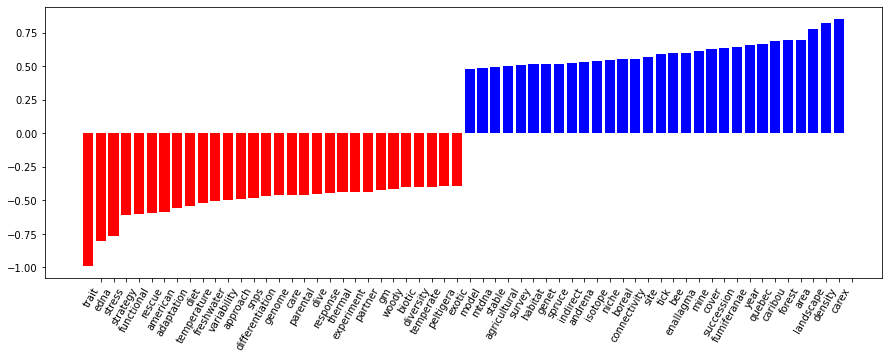

In [441]:
vec.fit(all_tokens)
X_train = vec.transform(all_tokens)
clf.fit(X_train, all_labels)
plot_coefficients(clf, vec.get_feature_names(), top_features=30)

In [196]:

d = {'url':df_species["url"].tolist(),'label':df_species["relevant"].tolist(), 'pred':t["pred_conf"], "pred_lab":t["pred_labels"]}

In [201]:
df = pd.DataFrame(d)
df

,url,label,pred,pred_lab
0,https://doi.org/10.5061/dryad.m0cfxpp47,0,-1.036231,0
1,https://doi.org/10.5061/dryad.q573n5tdx,0,-0.453066,0
2,https://doi.org/10.5061/dryad.r6s1c,1,0.346018,1
3,https://doi.org/10.5061/dryad.jk680,0,-0.422488,0
4,https://doi.org/10.5061/dryad.1c59zw3zf,1,0.100888,1
...,...,...,...,...
247,https://doi.org/10.5061/dryad.ft94b,0,-0.859239,0
248,https://doi.org/10.5061/dryad.3275s,0,-1.015995,0
249,https://doi.org/10.5061/dryad.2f050,0,-1.187807,0
250,https://doi.org/10.5061/dryad.931zcrjg3,0,-1.034201,0


In [209]:
a = "0"
b = "1"
df.query(("label == @a")).query("pred_lab == @b")

,url,label,pred,pred_lab
51,https://doi.org/10.5061/dryad.jwstqjqbr,0,0.159819,1
54,https://doi.org/10.25338/B83627,0,0.156061,1
61,https://doi.org/10.5061/dryad.vdncjsxvd,0,0.457681,1
63,https://doi.org/10.5061/dryad.5p6kr,0,0.228101,1
65,https://doi.org/10.5061/dryad.fxpnvx0ns,0,0.172458,1
68,https://doi.org/10.5061/dryad.72602,0,0.032584,1
75,https://doi.org/10.5061/dryad.2bvq83brd,0,0.656191,1
83,https://doi.org/10.5061/dryad.4k275,0,0.219829,1
96,https://doi.org/10.5061/dryad.tqjq2bvwz,0,0.503782,1
149,https://doi.org/10.5061/dryad.sj3tx967s,0,0.247829,1


In [210]:
c= "https://doi.org/10.5061/dryad.dncjsxm24"
df.query(("url == @c"))

,url,label,pred,pred_lab
127,https://doi.org/10.5061/dryad.dncjsxm24,0,-0.348457,0


In [206]:
df.pred_lab.tolist()

['0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0'

In [276]:
import logging
logging.basicConfig()

# import required modules
from cliff.api import Cliff
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize


ModuleNotFoundError: No module named 'cliff.api'